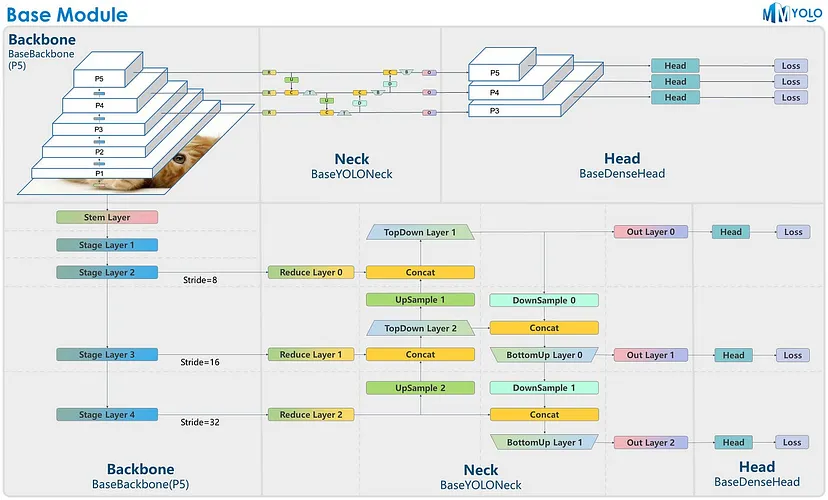

In [1]:
!pip install --quiet imutils
!pip install --quiet wget
!pip install --quiet split-folders
!pip install --quiet ultralytics


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import ultralytics
ultralytics.checks()

Ultralytics 8.3.58 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3887MiB)
Setup complete ✅ (20 CPUs, 15.2 GB RAM, 55.7/97.9 GB disk)


In [3]:
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import splitfolders
from torch import nn
import numpy as np
import os
import wget
from PIL import Image
import cv2
import requests
import tarfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

E0000 00:00:1736248943.425417   77964 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736248943.437592   77964 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
txt_path = "/home/a2ke5e1/Desktop/logo-detection-v2/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"

In [5]:
df = pd.read_csv(txt_path,
                 sep='\s+',
                 header=None)

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_77964/123307957.py:2: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


In [6]:
df.shape

(4531, 7)

In [7]:
columns = ['filename', 'class', 'sub-class','xmin', 'ymin', 'xmax', 'ymax']


In [8]:
df.columns = columns

In [9]:
df.head(5)

,filename,class,sub-class,xmin,ymin,xmax,ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


In [10]:
classes = df['class'].unique().tolist()

In [11]:
print("Classess = ",classes)
print("\n\nTotal Classess = ",len(classes))

Classess =  ['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex', 'Ferrari', 'Ford', 'Google', 'Heineken', 'HP', 'Intel', 'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma', 'RedBull', 'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone', 'Yahoo']


Total Classess =  27


In [12]:
class_mapping = {class_name: i for i, class_name in enumerate(classes)}

for class_name, class_no in class_mapping.items():
    print(f"{class_name}: {class_no}")

Adidas: 0
Apple: 1
BMW: 2
Citroen: 3
Cocacola: 4
DHL: 5
Fedex: 6
Ferrari: 7
Ford: 8
Google: 9
Heineken: 10
HP: 11
Intel: 12
McDonalds: 13
Mini: 14
Nbc: 15
Nike: 16
Pepsi: 17
Porsche: 18
Puma: 19
RedBull: 20
Sprite: 21
Starbucks: 22
Texaco: 23
Unicef: 24
Vodafone: 25
Yahoo: 26


## Removing Invalid Images and Invalid Bounding Boxes

In [13]:
def is_valid_image(img_path):
    try:
        Image.open(img_path).verify()
        return True
    except (IOError, SyntaxError):
        return False

def remove_broken_and_invalid_entries(folder_path, annotation_file_path):

    total_images_before = len(os.listdir(folder_path))

    with open(annotation_file_path, 'r') as file:
        total_entries_before = len(file.readlines())

    # Read the annotation file into a list
    with open(annotation_file_path, 'r') as file:
        annotations = file.readlines()

    # Filter out broken and invalid entries
    valid_annotations = []
    for annotation in annotations:
        parts = annotation.split()
        img_name, class_name, _, xmin, ymin, xmax, ymax = parts

        # Check if image is valid
        img_path = os.path.join(folder_path, img_name)
        if not is_valid_image(img_path):
            continue

        # Check if bounding box is valid
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
        if xmin >= xmax or ymin >= ymax:
            continue

        # If both checks pass, add the annotation to the valid list
        valid_annotations.append(annotation)

    # Update the annotation file
    with open(annotation_file_path, 'w') as file:
        file.writelines(valid_annotations)

    # Remove broken and invalid images
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            img_path = os.path.join(root, file)
            if not is_valid_image(img_path):
                os.remove(img_path)
            else:
                img_name = file
                annotation_exists = any(img_name in annotation for annotation in valid_annotations)
                if not annotation_exists:
                    print(img_path)
                    os.remove(img_path)

    # Count the total number of images after removal
    total_images_after = len(os.listdir(folder_path))

    total_entries_after = len(valid_annotations)

    print(f"Total number of entries before: {total_entries_before}")
    print(f"Total number of entries after Removal: {total_entries_after}")

    print(f"Total number of images before Removal: {total_images_before}")
    print(f"Total number of images after Removal: {total_images_after}")

In [14]:
folder_path = "/home/a2ke5e1/Desktop/logo-detection-v2/flickr_logos_27_dataset/flickr_logos_27_dataset_images"
annotation_file_path = "/home/a2ke5e1/Desktop/logo-detection-v2/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"
remove_broken_and_invalid_entries(folder_path, annotation_file_path)

Total number of entries before: 4531
Total number of entries after Removal: 4531
Total number of images before Removal: 808
Total number of images after Removal: 808


In [15]:
df = pd.read_csv("/home/a2ke5e1/Desktop/logo-detection-v2/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt",
                 sep='\s+',
                 header=None)
df.shape

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:2: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_77964/2941118535.py:2: SyntaxWarning: invalid escape sequence '\s'
  sep='\s+',


(4531, 7)

In [16]:
df.columns = columns

In [17]:
df.head(5)

,filename,class,sub-class,xmin,ymin,xmax,ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


## Preparing the Dataset

In [18]:
IMAGES_FOLDER_PATH = '/home/a2ke5e1/Desktop/logo-detection-v2/flickr_logos_27_dataset/flickr_logos_27_dataset_images'
OUTPUT_FOLDER_PATH = 'LOGOS'

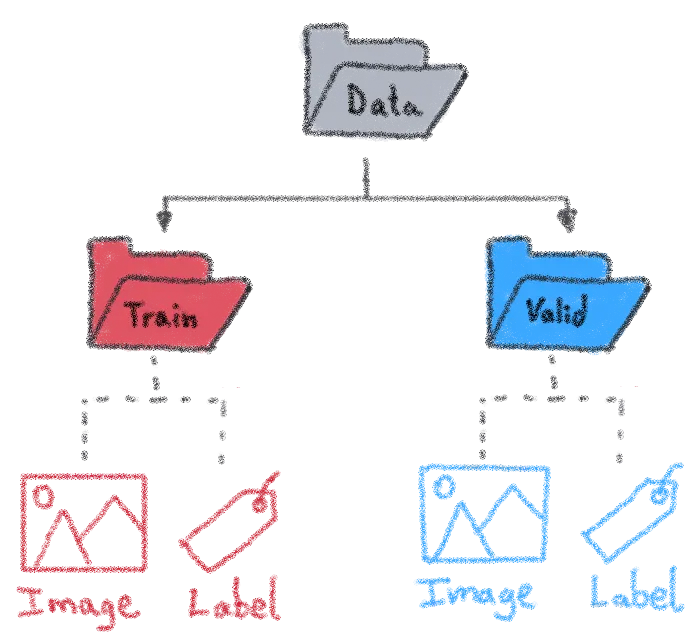

In [19]:
# Create folders
output_images_folder = os.path.join(OUTPUT_FOLDER_PATH, 'images')
output_labels_folder = os.path.join(OUTPUT_FOLDER_PATH, 'labels')
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)

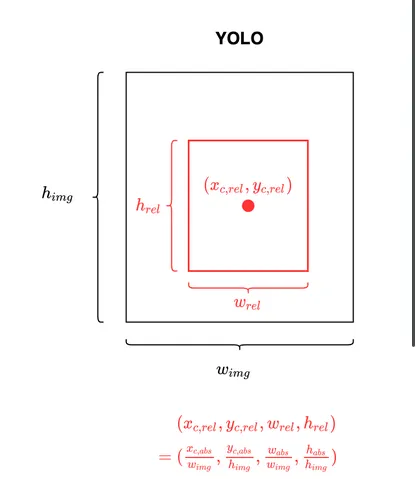

In [20]:
for idx, row in df.iterrows():
    filename = row['filename']
    class_name = row['class']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Read image
    image_path = os.path.join(IMAGES_FOLDER_PATH, filename)
    image = Image.open(image_path).convert("RGB")
    image_w, image_h = image.size

    # Calculate normalized bounding box coordinates
    b_center_x = (xmin + xmax) / 2
    b_center_y = (ymin + ymax) / 2
    b_width = (xmax - xmin)
    b_height = (ymax - ymin)

    b_center_x /= image_w
    b_center_y /= image_h
    b_width /= image_w
    b_height /= image_h

    # Save image
    output_image_path = os.path.join(output_images_folder, filename)
    image.save(output_image_path)

    # Save label file
    label_filename = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(output_labels_folder, label_filename)
    with open(label_path, 'w') as label_file:
        class_id = class_mapping[class_name]
        label_file.write(f"{class_id} {b_center_x} {b_center_y} {b_width} {b_height}")

print("Processing complete.")

Processing complete.


In [21]:
label_path = '/home/a2ke5e1/Desktop/logo-detection-v2/LOGOS/labels/2675240646.txt'
img = '/home/a2ke5e1/Desktop/logo-detection-v2/LOGOS/images/2675240646.jpg'
image = cv2.imread(img)

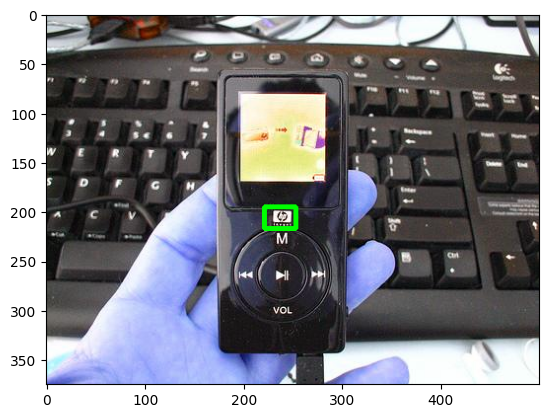

In [22]:
with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
        for label in labels:
          class_id, x_center, y_center, width, height = map(float, label.split())
          x_min = int((x_center - width/2) * image.shape[1])
          y_min = int((y_center - height/2) * image.shape[0])
          x_max = int((x_center + width/2) * image.shape[1])
          y_max = int((y_center + height/2) * image.shape[0])
          cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
          plt.imshow(image)

In [23]:
splitfolders.ratio('/home/a2ke5e1/Desktop/logo-detection-v2/LOGOS', output="data", seed=42, ratio=(0.8,0.2))


Copying files: 1616 files [00:00, 22734.80 files/s]


In [24]:
from ultralytics import YOLO

In [25]:
model = YOLO("yolov8n.pt")
dict_classes = model.model.names

In [26]:
dict_classes

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

## Setting up the YAML file

In [27]:
import yaml

In [28]:
data = {'train' :  '/home/a2ke5e1/Desktop/logo-detection-v2/data/train',
        'val' :  '/home/a2ke5e1/Desktop/logo-detection-v2/data/val',
        'test' :  '/home/a2ke5e1/Desktop/logo-detection-v2/data/val',
        'nc': len(classes),
        'names': classes
        }

In [29]:
file_path = 'data.yaml'
with open(file_path, 'w') as f:
    yaml.dump(data, f)

In [30]:
# read the content in .yaml file
with open('/home/a2ke5e1/Desktop/logo-detection-v2/data.yaml', 'r') as f:
    hamster_yaml = yaml.safe_load(f)
    display(hamster_yaml)

{'names': ['Adidas',
  'Apple',
  'BMW',
  'Citroen',
  'Cocacola',
  'DHL',
  'Fedex',
  'Ferrari',
  'Ford',
  'Google',
  'Heineken',
  'HP',
  'Intel',
  'McDonalds',
  'Mini',
  'Nbc',
  'Nike',
  'Pepsi',
  'Porsche',
  'Puma',
  'RedBull',
  'Sprite',
  'Starbucks',
  'Texaco',
  'Unicef',
  'Vodafone',
  'Yahoo'],
 'nc': 27,
 'test': '/home/a2ke5e1/Desktop/logo-detection-v2/data/val',
 'train': '/home/a2ke5e1/Desktop/logo-detection-v2/data/train',
 'val': '/home/a2ke5e1/Desktop/logo-detection-v2/data/val'}

In [31]:
print(len(model.names)) # 80 COCO dataset labels

80


In [32]:
data_path = '/home/a2ke5e1/Desktop/logo-detection-v2/data.yaml'

## Finetuning

In [33]:
# model.train(data=data_path, epochs=10, batch=10)
# model.train(data=data_path, epochs=20, batch=15) # 2.0G
# model.train(data=data_path, epochs=30, batch=20) # ~2.84G
model.train(data=data_path, epochs=30, batch=23) #



Ultralytics 8.3.58 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3887MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/a2ke5e1/Desktop/logo-detection-v2/data.yaml, epochs=30, time=None, patience=100, batch=23, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fal

train: Scanning /home/a2ke5e1/Desktop/logo-detection-v2/data/train/labels.cache... 646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 646/646 [00:00<?, ?it/s]
val: Scanning /home/a2ke5e1/Desktop/logo-detection-v2/data/val/labels.cache... 162 images, 0 backgrounds, 0 corrupt: 100%|██████████| 162/162 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000323, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005390625), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train6
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      3.17G      1.442      4.711       1.65          4        640: 100%|██████████| 29/29 [00:08<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.98it/s]

                   all        162        162          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      3.14G      1.209      4.425      1.471          7        640: 100%|██████████| 29/29 [00:07<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        162        162     0.0189      0.297     0.0838     0.0572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      3.27G      1.223      4.011      1.465          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        162        162      0.768      0.112      0.185      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      3.25G      1.182      3.619      1.418          6        640: 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        162        162      0.631      0.191      0.242      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      3.27G       1.21      3.352      1.451          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        162        162      0.552      0.301      0.328       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      3.15G      1.161      3.055       1.44          5        640: 100%|██████████| 29/29 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        162        162      0.531       0.34      0.416      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      3.26G      1.148      2.785      1.385          5        640: 100%|██████████| 29/29 [00:07<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        162        162      0.458      0.418      0.461      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      3.27G      1.148      2.789      1.372          5        640: 100%|██████████| 29/29 [00:07<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

                   all        162        162      0.572      0.477      0.541      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      3.27G      1.174      2.595      1.374          3        640: 100%|██████████| 29/29 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        162        162      0.505      0.491       0.53      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      3.25G      1.102      2.378      1.339          5        640: 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.96it/s]

                   all        162        162      0.607      0.526      0.576      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      3.27G      1.122      2.326       1.34          6        640: 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        162        162      0.625      0.514      0.616      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      3.15G      1.088      2.264      1.343          6        640: 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        162        162        0.6      0.613      0.641      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      3.26G      1.082      2.163      1.319          5        640: 100%|██████████| 29/29 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        162        162      0.703       0.56        0.6      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      3.15G      1.033      1.991      1.295          5        640: 100%|██████████| 29/29 [00:07<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

                   all        162        162      0.554      0.611      0.599      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      3.15G      1.013      1.969      1.302          5        640: 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        162        162      0.651      0.621      0.634      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      3.14G      1.033      1.921      1.266          5        640: 100%|██████████| 29/29 [00:07<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        162        162      0.653      0.631      0.661       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      3.27G      1.014      1.878      1.286          4        640: 100%|██████████| 29/29 [00:07<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        162        162      0.568      0.599      0.626      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      3.15G     0.9866      1.812      1.247          4        640: 100%|██████████| 29/29 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        162        162      0.625      0.585      0.623      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      3.26G     0.9773      1.785      1.243          6        640: 100%|██████████| 29/29 [00:07<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        162        162      0.581      0.643      0.642      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      3.15G     0.9779      1.893      1.245          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

                   all        162        162      0.656      0.622      0.653      0.441


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      3.14G     0.9717      2.344      1.327          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        162        162      0.654      0.627       0.66      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      3.14G     0.9588       2.34      1.305          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        162        162      0.603      0.648       0.64      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      3.27G     0.9254      2.154      1.253          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        162        162      0.651      0.632      0.651      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      3.15G     0.9179      2.139      1.263          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

                   all        162        162      0.695      0.641      0.682      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      3.26G     0.8444      2.054      1.204          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        162        162      0.691      0.633      0.673      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      3.15G     0.8255      2.035      1.167          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        162        162      0.703      0.635       0.68       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      3.15G     0.8597      2.019      1.202          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        162        162      0.686      0.661       0.69      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      3.14G     0.8093      1.927      1.159          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

                   all        162        162      0.695      0.653      0.686      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      3.27G     0.7953      1.946      1.178          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

                   all        162        162      0.651      0.683      0.682      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      3.15G     0.8144       1.96      1.171          2        640: 100%|██████████| 29/29 [00:07<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        162        162      0.702      0.627      0.671      0.452



30 epochs completed in 0.071 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 6.2MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.58 🚀 Python-3.12.7 torch-2.5.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3050 Laptop GPU, 3887MiB)
Model summary (fused): 168 layers, 3,010,913 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]


                   all        162        162      0.691      0.632      0.673      0.463
                Adidas          7          7          1      0.423      0.596       0.45
                 Apple          9          9      0.592      0.325      0.301       0.17
                   BMW          7          7      0.691      0.644      0.802      0.402
               Citroen          7          7      0.838      0.429      0.579      0.364
              Cocacola          5          5      0.603        0.4      0.403      0.344
                   DHL          6          6      0.793      0.644      0.753      0.381
                 Fedex          4          4       0.73          1      0.995      0.578
               Ferrari         11         11       0.77      0.545      0.639      0.329
                  Ford         10         10      0.894        0.8      0.944      0.741
                Google          7          7      0.844       0.78      0.776      0.576
              Heineke

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d180fdaafc0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.0

## Prediction

In [34]:
def predict(src):
  result_predict = model.predict(source = src)
  plot = result_predict[0].plot()
  plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
  display(Image.fromarray(plot))



image 1/1 /home/a2ke5e1/Desktop/logo-detection-v2/data/val/images/2126991906.jpg: 192x640 1 Yahoo, 28.0ms
Speed: 2.0ms preprocess, 28.0ms inference, 0.6ms postprocess per image at shape (1, 3, 192, 640)


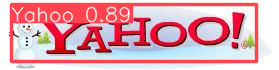

In [35]:
path = '/home/a2ke5e1/Desktop/logo-detection-v2/data/val/images/2126991906.jpg'
predict(path)


image 1/1 /home/a2ke5e1/Desktop/logo-detection-v2/data/val/images/1690276845.jpg: 480x640 1 Porsche, 25.8ms
Speed: 1.7ms preprocess, 25.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


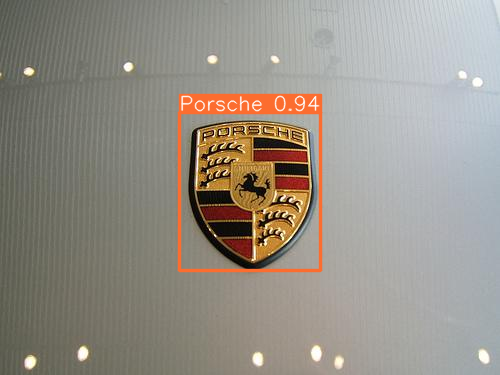

In [36]:
path = '/home/a2ke5e1/Desktop/logo-detection-v2/data/val/images/1690276845.jpg'
predict(path)


image 1/1 /home/a2ke5e1/Desktop/logo-detection-v2/data/val/images/582467906.jpg: 480x640 1 Intel, 4.2ms
Speed: 3.2ms preprocess, 4.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


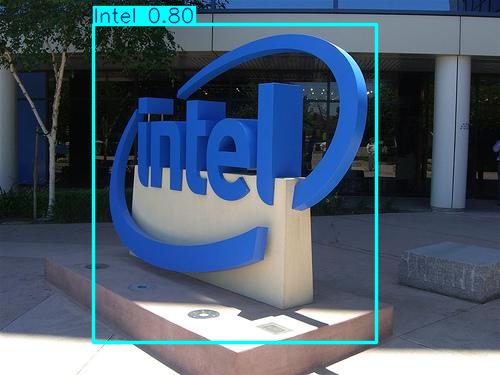

In [37]:
path = "/home/a2ke5e1/Desktop/logo-detection-v2/data/val/images/582467906.jpg"
predict(path)
